In [157]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from  torchvision.datasets import ImageFolder
import numpy as np
import torch.nn.functional as F

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [158]:
path = '../HW3/lfw/lfw'

In [176]:
from torchvision import transforms

#Resizing Image to 128*128 as my machine was not able to handle 250*250 Image size computation
transform = transforms.Compose([
    transforms.Resize((128, 128)),    # Resize to 128*128
    transforms.ToTensor()             # Convert images to Tensor
])

# Create DataLoader
dataloader = DataLoader(ImageFolder(path, transform=transform), batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [160]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Set the device to CUDA
    device = torch.device("cuda")
    print("CUDA device is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    # Fallback to CPU if CUDA is not available
    device = torch.device("cpu")
    print("CUDA device not found. Using CPU.")

CUDA device is available. Using GPU: NVIDIA GeForce GTX 1660 Ti


torch.Size([128, 128, 3])


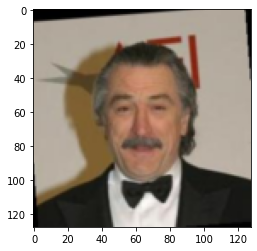

In [161]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

Let's start with the context of Autoencoders. I like to think of them as diligent artists who can create a sketch of any scene. The way they work is by compressing the scene into a simpler form (which we call the encoded representation or latent space) and then reconstructing it back to the original scene as closely as possible. They are great for tasks like dimensionality reduction or feature learning. For example, if I had a bunch of images of faces, an AE could help me compress these images into a smaller set of features that still capture the essence of the images, and then it could try to recreate the original faces from these features.

Now, when it comes to Variational Autoencoders, imagine an artist who not only sketches but also adds a touch of creativity by introducing variations. VAEs are similar to AEs in that they encode inputs into a latent space and then reconstruct outputs from this space. However, VAEs are designed to model the underlying probability distribution of the data. They introduce a bit of randomness in the encoding process, which means that each time I encode an image of a face, I might get a slightly different representation. This variability allows VAEs to generate new data that's similar to the input data, making them incredibly useful for generative tasks—like if I wanted to create new, imaginary faces that weren't in the original dataset.

Architecturally, both AEs and VAEs have an encoder and a decoder, but VAEs have a twist: the encoder outputs two things for each input—means and variances, which represent the parameters of a probability distribution. The latent representation is then sampled from this distribution. It's like saying, "Instead of telling you exactly what the sketch looks like, I'll give you a range of possibilities, and you can pick one." This is what allows VAEs to generate new, diverse outputs.

In terms of the loss function, an AE typically uses a straightforward loss like MSE that measures how different the reconstructed output is from the original input. The VAE, on the other hand, has a more complex loss function. It includes a reconstruction loss, just like the AE, but it adds a second term called the Kullback-Leibler (KL) divergence. This term measures how much the learned distribution (from which we're sampling our latent variables) deviates from a standard normal distribution. It's like the AE's loss function checks "Did I draw this right?" while the VAE's loss function asks "Did I draw this right, and does the range of sketches I could have drawn make sense statistically?"

In a nutshell, AEs are about compression and reconstruction, while VAEs are about understanding data in a probabilistic way and generating new data. If you've worked with AEs before and you want to move into the world of VAEs, you'd typically start by altering your encoder to produce means and variances, and then tweak your loss function to include the KL divergence. And there you have it, a generative model ready to create new and diverse outputs from your data.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [6]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class VAE(nn.Module):
#     def __init__(self):
#         super(VAE, self).__init__()

#         # Encoder
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)  # Output: [32, 125, 125]
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # Output: [64, 63, 63]
#         self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # Output: [128, 32, 32]
#         self.bn3 = nn.BatchNorm2d(128)
#         self.fc1 = nn.Linear(123008, 2048)
#         self.fc21 = nn.Linear(2048, 400)  # Mean
#         self.fc22 = nn.Linear(2048, 400)  # Log variance
#         self.dropout = nn.Dropout(p=0.5)

#         # Decoder
#         self.fc3 = nn.Linear(400, 2048)
#         self.fc4 = nn.Linear(2048, 128 * 31 * 31)
#         self.conv4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # Upsample to [64, 62, 62]
#         self.bn4 = nn.BatchNorm2d(64)
#         # Adjust conv5 to increase output size
#         self.conv5 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=1)  # Upsample to [32, 125, 125]
#         self.bn5 = nn.BatchNorm2d(32)
#         # Adjust conv6 to achieve the final target size
#         self.conv6 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, output_padding=0)  # Upsample to [3, 250, 250]



#     def encoder(self, x):
#         h = F.relu(self.bn1(self.conv1(x)))
#         h = F.relu(self.bn2(self.conv2(h)))
#         h = F.relu(self.bn3(self.conv3(h)))
#         h = h.view(h.size(0), -1)
#         h = self.dropout(F.relu(self.fc1(h)))
#         return self.fc21(h), self.fc22(h)

#     def reparameterize(self, mean, log_var):
#         std = torch.exp(0.5 * log_var)
#         eps = torch.randn_like(std)
#         return mean + eps * std

#     def decoder(self, z):
#         h = F.relu(self.fc3(z))
#         h = F.relu(self.fc4(h))
#         h = h.view(-1, 128, 31, 31)
#         h = F.relu(self.bn4(self.conv4(h)))
#         h = F.relu(self.bn5(self.conv5(h)))
#         reconstructed_img = torch.sigmoid(self.conv6(h))
#         return reconstructed_img

#     def forward(self, x):
#         mean, log_var = self.encoder(x)
#         z = self.reparameterize(mean, log_var)
#         return self.decoder(z), mean, log_var


In [37]:
# Architecture for Input Image Size 3*28*28
# class VAE(nn.Module):
#     def __init__(self):
#         super(VAE, self).__init__()

#         # Encoder
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)  # Output: [32, 14, 14]
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # Output: [64, 7, 7]
#         self.bn2 = nn.BatchNorm2d(64)
#         # Removed one convolutional layer due to smaller input size
#         self.fc1 = nn.Linear(64 * 7 * 7, 1024) 
#         self.fc21 = nn.Linear(1024, 400)  # Mean
#         self.fc22 = nn.Linear(1024, 400)  # Log variance
#         self.dropout = nn.Dropout(p=0.5)

#         # Decoder
#         self.fc3 = nn.Linear(400, 1024)
#         self.fc4 = nn.Linear(1024, 64 * 7 * 7)
#         self.conv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # Upsample to [32, 14, 14]
#         self.bn4 = nn.BatchNorm2d(32)
#         self.conv5 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, output_padding=0)  # Upsample to [3, 28, 28]

#     def encoder(self, x):
#         h = F.relu(self.bn1(self.conv1(x)))
#         h = F.relu(self.bn2(self.conv2(h)))
#         # h = F.relu(self.bn3(self.conv3(h)))
#         h = h.view(h.size(0), -1)
#         h = self.dropout(F.relu(self.fc1(h)))
#         return self.fc21(h), self.fc22(h)

#     def reparameterize(self, mean, log_var):
#         std = torch.exp(0.5 * log_var)
#         eps = torch.randn_like(std)
#         return mean + eps * std

#     def decoder(self, z):
#         h = F.relu(self.fc3(z))
#         h = F.relu(self.fc4(h))
#         h = h.view(-1, 64, 7, 7)
#         h = F.relu(self.bn4(self.conv4(h)))
#         reconstructed_img = torch.sigmoid(self.conv5(h))
#         return reconstructed_img

#     def forward(self, x):
#         mean, log_var = self.encoder(x)
#         z = self.reparameterize(mean, log_var)
#         return self.decoder(z), mean, log_var


In [78]:
# # Architecture for Input Image Size 3*64*64

# class VAE(nn.Module):
#     def __init__(self):
#         super(VAE, self).__init__()

#         # Encoder
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)  # [32, 32, 32]
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # [64, 16, 16]
#         self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # [128, 8, 8]
#         self.bn3 = nn.BatchNorm2d(128)
#         self.fc1 = nn.Linear(128 * 8 * 8, 1024)  
#         self.fc21 = nn.Linear(1024, 400)  # Mean
#         self.fc22 = nn.Linear(1024, 400)  # Log variance
#         self.dropout = nn.Dropout(p=0.5)

#         # Decoder
#         self.fc3 = nn.Linear(400, 1024)
#         self.fc4 = nn.Linear(1024, 128 * 8 * 8)
#         self.conv4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # [64, 16, 16]
#         self.bn4 = nn.BatchNorm2d(64)
#         self.conv5 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # [32, 32, 32]
#         self.bn5 = nn.BatchNorm2d(32)
#         self.conv6 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)  # [3, 64, 64]

#     def encoder(self, x):
#         h = F.relu(self.bn1(self.conv1(x)))
#         h = F.relu(self.bn2(self.conv2(h)))
#         h = F.relu(self.bn3(self.conv3(h)))
#         h = h.view(h.size(0), -1)
#         h = self.dropout(F.relu(self.fc1(h)))
#         return self.fc21(h), self.fc22(h)

#     def reparameterize(self, mean, log_var):
#         std = torch.exp(0.5 * log_var)
#         eps = torch.randn_like(std)
#         return mean + eps * std

#     def decoder(self, z):
#         h = F.relu(self.fc3(z))
#         h = F.relu(self.fc4(h))
#         h = h.view(-1, 128, 8, 8)
#         h = F.relu(self.bn4(self.conv4(h)))
#         h = F.relu(self.bn5(self.conv5(h)))
#         reconstructed_img = torch.sigmoid(self.conv6(h))
#         return reconstructed_img

#     def forward(self, x):
#         mean, log_var = self.encoder(x)
#         z = self.reparameterize(mean, log_var)
#         return self.decoder(z), mean, log_var


In [162]:
# Architecture for Input Image Size 3*128*128

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)  # Output size: [32, 64, 64]
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # Output size: [64, 32, 32]
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # Output size: [128, 16, 16]
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)  # Output size: [256, 8, 8]
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)  
        self.fc21 = nn.Linear(1024, 400)  # Mean
        self.fc22 = nn.Linear(1024, 400)  # Log variance
        self.dropout = nn.Dropout(p=0.5)

        # Decoder
        self.fc3 = nn.Linear(400, 1024)
        self.fc4 = nn.Linear(1024, 256 * 8 * 8)
        self.conv5 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # [128, 16, 16]
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # [64, 32, 32]
        self.bn6 = nn.BatchNorm2d(64)
        self.conv7 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # [32, 64, 64]
        self.bn7 = nn.BatchNorm2d(32)
        self.conv8 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)  # [3, 128, 128]

    def encoder(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = F.relu(self.bn2(self.conv2(h)))
        h = F.relu(self.bn3(self.conv3(h)))
        h = F.relu(self.bn4(self.conv4(h)))
        h = h.view(h.size(0), -1)
        h = self.dropout(F.relu(self.fc1(h)))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decoder(self, z):
        h = F.relu(self.fc3(z))
        h = F.relu(self.fc4(h))
        h = h.view(-1, 256, 8, 8)
        h = F.relu(self.bn5(self.conv5(h)))
        h = F.relu(self.bn6(self.conv6(h)))
        h = F.relu(self.bn7(self.conv7(h)))
        reconstructed_img = torch.sigmoid(self.conv8(h))
        return reconstructed_img

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        return self.decoder(z), mean, log_var


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [163]:
# Creating an instance of the VAE
vae = VAE().to(device)

dataiter = iter(dataloader)
images, labels = dataiter.__next__()  
images = images.to(device)

# Pass an image through the encoder
mean, log_var = vae.encoder(images)
print("Shape of encoder output (mean):", mean.shape)
print("Shape of encoder output (log_var):", log_var.shape)

# Using the decoder to generate images
# Let's take one sample from the batch for simplicity
sampled_z = vae.reparameterize(mean[0], log_var[0]).unsqueeze(0)
reconstructed_img = vae.decoder(sampled_z)
print("Shape of decoder output:", reconstructed_img.shape)

Shape of encoder output (mean): torch.Size([32, 400])
Shape of encoder output (log_var): torch.Size([32, 400])
Shape of decoder output: torch.Size([1, 3, 128, 128])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


In [164]:
total_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print("Total number of parameters:", total_params)

Total number of parameters: 36183907


* create an optimizer for training

In [168]:
# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [170]:
def loss_function(output, img, mu_f, logvar_f, beta=0.5):
    # Reconstruction loss
    recon_loss = F.mse_loss(output.view(-1, 128*128*3), img.view(-1, 128*128*3), reduction='sum')
    
    # KL Divergence
    kl_loss = -0.5 * torch.sum(1 + logvar_f - mu_f.pow(2) - logvar_f.exp())
    
    # Total loss
    return recon_loss + beta * kl_loss

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [171]:
import torch
import torch.nn.functional as F
import torch.optim as optim

# Training loop
num_epochs = 50
lowest_loss = float('inf')
early_stopping_counter = 0
early_stopping_limit = 10  # Stop training if no improvement for 10 epochs

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mean, log_var = vae(data)
        loss = loss_function(recon_batch, data, mean, log_var, beta=1.0)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader.dataset)
    scheduler.step(avg_loss)  # Update the learning rate based on the average loss
    
    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')
    
    # Early stopping check
    if avg_loss < lowest_loss:
        lowest_loss = avg_loss
        early_stopping_counter = 0
        torch.save(vae.state_dict(), 'vae_best_model.pth')
        print('Model saved as vae_best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_limit:
            print("Early stopping triggered.")
            break

Epoch 1/50, Average Loss: 2392.0367
Model saved as vae_best_model.pth
Epoch 2/50, Average Loss: 2141.4296
Model saved as vae_best_model.pth
Epoch 3/50, Average Loss: 1986.3901
Model saved as vae_best_model.pth
Epoch 4/50, Average Loss: 1903.9886
Model saved as vae_best_model.pth
Epoch 5/50, Average Loss: 1846.4380
Model saved as vae_best_model.pth
Epoch 6/50, Average Loss: 1811.8610
Model saved as vae_best_model.pth
Epoch 7/50, Average Loss: 1775.8127
Model saved as vae_best_model.pth
Epoch 8/50, Average Loss: 1751.6462
Model saved as vae_best_model.pth
Epoch 9/50, Average Loss: 1728.2237
Model saved as vae_best_model.pth
Epoch 10/50, Average Loss: 1705.6743
Model saved as vae_best_model.pth
Epoch 11/50, Average Loss: 1688.7610
Model saved as vae_best_model.pth
Epoch 12/50, Average Loss: 1675.5794
Model saved as vae_best_model.pth
Epoch 13/50, Average Loss: 1661.5445
Model saved as vae_best_model.pth
Epoch 14/50, Average Loss: 1645.9128
Model saved as vae_best_model.pth
Epoch 15/50, Av

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

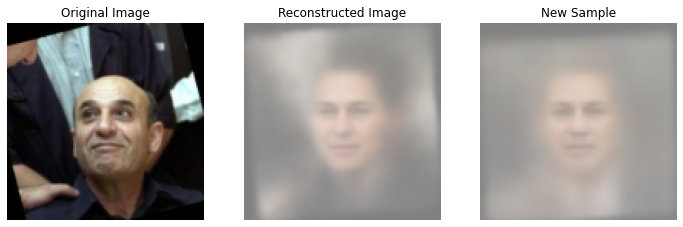

In [175]:
import matplotlib.pyplot as plt
import torch

def to_img(x):
    """Converts a tensor to an image."""
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 128, 128)  # Adjust the size based on your dataset (28x28 in this case)
    return x

# Set the model to evaluation mode
vae.eval()

# Ensure the model and data are on the same device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = vae.to(device)

# Load a random image from the dataset
dataiter = iter(dataloader)
images, _ = next(dataiter)
img = images[0].unsqueeze(0).to(device)  # Take the first image in the batch

# Generate a reconstructed image
recon_img, _, _ = vae(img)
recon_img = to_img(recon_img.cpu().data)

# Generate new samples
with torch.no_grad():
    z = torch.randn(1, 400).to(device)  # 400 is the size of the latent space
    sample_img = vae.decoder(z)
    sample_img = to_img(sample_img.cpu().data)

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img.cpu().squeeze().permute(1, 2, 0))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Reconstructed Image")
plt.imshow(recon_img.squeeze().permute(1, 2, 0))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("New Sample")
plt.imshow(sample_img.squeeze().permute(1, 2, 0))
plt.axis('off')

plt.show()
